Attempt to build my own BEV model instead

In [1]:
from train_nuscenes import *
from nuscenesdataset import * 
# data_dir='../nuscenes/
data_dir = '/mnt/d/Data/NuScene-mini'
%matplotlib inline
from nuscenes.nuscenes import NuScenes
from nuscenes.nuscenes import NuScenesExplorer
from PIL import Image
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix

# NuScene dataset reader
nusc = NuScenes(version='v1.0-mini', dataroot=data_dir, verbose=True)
nusc_exp = NuScenesExplorer(nusc)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.868 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
crop_offset = 0
resize_lim = [1.0,1.0]
res_scale=2
final_dim = (int(224 * res_scale), int(400 * res_scale))
ncams = 6
print('resolution:', final_dim)
data_aug_conf = {
        'crop_offset': crop_offset,
        'resize_lim': resize_lim,
        'final_dim': final_dim,
        'H': 900, 'W': 1600,
        'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
                 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'],
        'ncams': ncams,
    }

# nusc, is_train, data_aug_conf, centeroid, bounds, res_3d,
# nsweeps, seqlen, refcam_id, get_tids, temporal_aug, use_radar_filters,
# do_shuffle_cams
bounds3d = 0,100,-20,20, 0,3
resolution3d = 100.0, 40.0, 3.0


nudata = NuscData(nusc, True, data_aug_conf, bounds=bounds3d, res_3d=resolution3d)

resolution: (448, 800)
indices (323, 1)
NuscData: 323 samples. Split: train.
                   Augmentation Conf: {'crop_offset': 0, 'resize_lim': [1.0, 1.0], 'final_dim': (448, 800), 'H': 900, 'W': 1600, 'cams': ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT'], 'ncams': 6}


In [3]:
nudata.get_scenes()
# sorted sample scenes according to timestamp
sorted_samples = nudata.prepro()

samp = sorted_samples[1]
cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
# Get image data, works on camera to get their cam2ego_cam parameter with intrinsic parameter
imgs, rots, trans, intrins = nudata.get_image_data(samp, cams[1:2])
# Image bin gives BEV visilization under the given Resolution parameters, together with ego2glob_lidar calibration
img_bin, glob2ego_lidar = nudata.get_binimg(samp)
# 
lrtlist, boxlist, vislist, tidlist = nudata.get_lrtlist(samp)
#
binimg, trans = nudata.get_binimg(samp)

In [4]:
rec = nusc.sample[5]

In [6]:
egopose = nusc.get('ego_pose', nusc.get('sample_data', rec['data']['LIDAR_TOP'])['ego_pose_token'])
trans = -np.array(egopose['translation'])
rot = Quaternion(egopose['rotation']).inverse
img = np.zeros((nudata.nx[0], nudata.nx[1]))

for ii, tok in enumerate(rec['anns']):
    inst = nusc.get('sample_annotation', tok)

    # NuScenes filter
    if 'vehicle' not in inst['category_name']:
        continue
    if discard_invisible and int(inst['visibility_token']) == 1:
        # filter invisible vehicles
        continue

    box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
    box.translate(trans)
    box.rotate(rot)

    pts = box.bottom_corners()[:2].T
    print(box.bottom_corners()[:2])
    pts = np.round(
        (pts - nudata.bx[:2] + nudata.dx[:2]/2.) / nudata.dx[:2]
        ).astype(np.int32)
    pts[:, [1, 0]] = pts[:, [0, 1]]
    cv2.fillPoly(img, [pts], ii+1.0)

[[ 44.23758207  42.23412057  41.83956868  43.84303018]
 [-36.79901451 -36.62716134 -41.24228454 -41.41413772]]
[[ 40.34771927  39.66344931  39.86874048  40.55301045]
 [-19.33488672 -19.41458495 -21.17234776 -21.09264953]]
[[61.6351526  64.13297473 64.70531738 62.20749525]
 [25.45639479 25.23317587 31.65827646 31.88149538]]
[[39.33701913 40.01844225 41.3332074  40.65178428]
 [17.77526081 17.27726646 19.07635052 19.57434487]]
[[21.94688577 22.1197624  18.13082094 17.9579443 ]
 [-8.07203878 -6.37320424 -5.96615161 -7.66498615]]
[[ 0.68261146  0.70600081 -9.49348484 -9.51687419]
 [ 3.02881736  5.90514039  5.99116268  3.11483965]]
[[56.55175496 58.67809078 59.11772658 56.99139076]
 [ 3.80922302  3.61920212  8.55453978  8.74456067]]
[[ 45.18402706  43.25229566  42.84190379  44.77363518]
 [-28.87049666 -28.70479635 -33.50520186 -33.67090217]]
[[48.54485797 51.54861854 51.90274003 48.89897946]
 [ 8.65080827  8.38237594 12.35773266 12.62616499]]
[[ 50.7111778   48.74311652  48.45504568  50.4231

In [ ]:
def get_binimg(self, rec):
    egopose = self.nusc.get('ego_pose', self.nusc.get('sample_data', rec['data']['LIDAR_TOP'])['ego_pose_token'])
    trans = -np.array(egopose['translation'])
    rot = Quaternion(egopose['rotation']).inverse
    img = np.zeros((self.nx[0], self.nx[1]))
    for ii, tok in enumerate(rec['anns']):
        inst = self.nusc.get('sample_annotation', tok)

        if not self.is_lyft:
            # NuScenes filter
            if 'vehicle' not in inst['category_name']:
                continue
            if discard_invisible and int(inst['visibility_token']) == 1:
                # filter invisible vehicles
                continue
        else:
            # Lyft filter
            if inst['category_name'] not in ['bus', 'car', 'construction_vehicle', 'trailer', 'truck']:
                continue

        box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
        box.translate(trans)
        box.rotate(rot)

        pts = box.bottom_corners()[:2].T
        pts = np.round(
            (pts - self.bx[:2] + self.dx[:2]/2.) / self.dx[:2]
            ).astype(np.int32)
        pts[:, [1, 0]] = pts[:, [0, 1]]
        cv2.fillPoly(img, [pts], ii+1.0)


* Rebuild of Nusc BEV Dataset: Version that is completely ready for visualization
* Make use of the smaller functionals, not the big & dumb skeletons

In [11]:
from player import *

class Nusc_bev(torch.utils.data.Dataset):
    def __init___(self, nusc, is_train, data_aug_conf, centroid=None, bounds=None, res_3d=None,
                  nsweeps=1, seqlen=1, refcam_id=1):
        self.nusc = nusc
        # self.is_train = is_train
        # self.data_aug_conf = data_aug_conf
        # self.grid_conf = grid_conf
        self.nsweeps = nsweeps
        self.res_3d = res_3d
        self.bounds = bounds
        self.centroid = centroid

        self.seqlen = seqlen
        self.refcam_id = refcam_id
        self.dataroot = self.nusc.dataroot
        self.prepro()
        self.scenes = self.get_scenes()
        
    def __new__(cls, nusc, is_train, data_aug_conf, centroid=None, bounds=None, res_3d=None,
                  nsweeps=1, seqlen=1, refcam_id=1):
        print("Creating Instance")
        instance = super(Nusc_bev, cls).__new__(cls)
        return instance
        
    def get_scenes(self):
        # filter by scene split
        split = {
            'v1.0-trainval': {True: 'train', False: 'val'},
            'v1.0-mini': {True: 'mini_train', False: 'mini_val'},
        }[self.nusc.version][self.is_train]
        scenes = create_splits_scenes()[split]
        return scenes
    
    def prepro(self):
        samples = [samp for samp in self.nusc.sample]
        # remove samples that aren't in this split
        samples = [samp for samp in samples if self.nusc.get('scene', samp['scene_token'])['name'] in self.scenes]
        # sort by scene, timestamp (only to make chronological viz easier)
        samples.sort(key=lambda x: (x['scene_token'], x['timestamp']))
        return samples
    
    # Get 3D BBox under Ego vehicle cooridnate -- timestamp same as the reference camera (FRONT CAM)
    def get_bev_bbox(self, idx):
        samp = nusc.sample[idx]
        self.cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
        imgs = []
        img_metas = []
        # 3D Box objects under ego vehicle coordinate
        boxes_ego = []
        extrins = []
        intrins = []

        # Lidar Sensor Information
        lid_rec = nusc.get('sample_data', samp['data']['LIDAR_TOP'])
        lid_egopose = nusc.get('ego_pose', lid_rec['ego_pose_token'])
        # print('Lidar ', np.array(lid_egopose['translation']))
        lid_calib = nusc.get('calibrated_sensor', lid_rec['calibrated_sensor_token'])

        # LIDAR 3DBBox
        pc_path, boxes_lid, _ = nusc.get_sample_data(samp['data']['LIDAR_TOP'])

        # Reference Camera Information : Front Camera Chosen
        refcam = 'CAM_FRONT'
        refcam_rec = nusc.get('sample_data', samp['data'][refcam])
        refcam_egopose = nusc.get('ego_pose', refcam_rec['ego_pose_token'])
        refcam_calib = nusc.get('calibrated_sensor', refcam_rec['calibrated_sensor_token'])
        glob2ego_refcam = unpack_rot_trans(refcam_egopose, inverse=True)

        # 3D Bbox collection: Convert from Lidar coordiante towards Ego vehicle -- refcam timestamp
        for box in boxes_lid:
            # lid2ego_lid
            box.rotate(Quaternion(lid_calib['rotation']))
            box.translate(np.array(lid_calib['translation']))
            #ego_lid2glob
            box.rotate(Quaternion(lid_egopose['rotation']))
            box.translate(np.array(lid_egopose['translation']))
            #glob2ego_refcam
            box.translate(-np.array(refcam_egopose['translation']))
            box.rotate(Quaternion(refcam_egopose['rotation']).inverse)
            boxes_ego.append(box)

        # Images & Image Metas collection
        for cam in cams:
            cam_rec = nusc.get('sample_data', samp['data'][cam])
            # For all cameras, camera pose are the same
            cam_egopose = nusc.get('ego_pose', cam_rec['ego_pose_token'])
            cam_calib = nusc.get('calibrated_sensor', cam_rec['calibrated_sensor_token'])
            # INTRINSIC
            img_path, boxes_cam, camera_intrinsic = nusc.get_sample_data(samp['data'][cam])
            intrins.append(camera_intrinsic)
            # (print(cam, np.array(cam_egopose['translation'])))
            imgs.append(Image.open(img_path))
            # extrinsic, cam2ego (ego-front-cam, we ignore the different between camers)
            # so the front-camera would be the most accurate camera on which we provide our estimate
            # cam2ego(cam) -> ego(cam)2glob -> glob2ego(refcam) = cam2ego (refcam) = extrinsic
            cam2ego_cam = unpack_rot_trans(cam_calib)
            ego_cam2glob = unpack_rot_trans(cam_egopose)
            cam2ego_refcam = glob2ego_refcam @ ego_cam2glob @ cam2ego_cam
            extrins.append(cam2ego_refcam)

        return imgs, img_metas, boxes_ego, intrins, extrins
    
    def visualize_bev_box(self, idx, refcam='CAM_FRONT'):
        # bev box obtained 
        imgs, img_metas, boxes_ego, intrins, extrins = self.get_bev_bbox(idx)
        
        samp = nusc.sample[idx]
        refcam_rec = nusc.get('sample_data', samp['data'][refcam])
        refcam_calib = nusc.get('calibrated_sensor', refcam_rec['calibrated_sensor_token'])
        
        # visualize on refcam : Front Camera
        img_path, _, camera_intrinsic = nusc.get_sample_data(samp['data'][refcam])
        # read image
        img = Image.open(img_path)
        # Init axes
        _, ax = plt.subplots(1, 1, figsize=(9, 16))
        # Plot image
        ax.imshow(img)

        # This should now resides under camera coordinate
        for box in boxes_ego:
            box.translate(-np.array(refcam_calib['translation']))
            box.rotate(Quaternion(refcam_calib['rotation']).inverse)
            if box.center[2]<=1 or abs(box.center[0])>=10 or not(box.name.startswith('human') or box.name.startswith('vehicle')):
                continue
            c = np.array(nusc.explorer.get_color(box.name)) / 255.0
            box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

In [12]:
# Visualize under bin image sense:



In [13]:
nusc_bev = Nusc_bev(nusc, False, data_aug_conf)

imgs, img_metas, boxes_ego, intrins, extrins = nusc_bev.get_bev_bbox(3)

Creating Instance


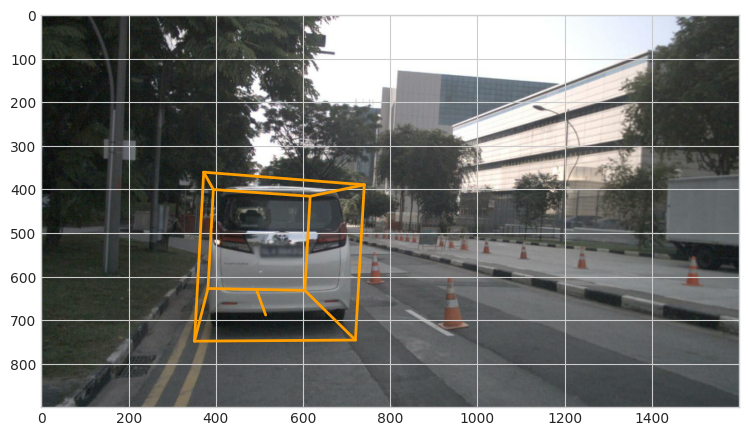

In [14]:
nusc_bev.visualize_bev_box(24, refcam='CAM_FRONT')

* Time of data collection from each sensor (Cam & Lidar) are all different, we have to pretend all camera infos are colllected at the same timestamp...
* Some Fancier method can be to self-super

In [15]:
samp = nusc.sample[1]
cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']

imgs = []
img_metas = []
# 3D Box objects under ego vehicle coordinate
boxes_ego = []
extrins = []
intrins = []

# Lidar Sensor Information
lid_rec = nusc.get('sample_data', samp['data']['LIDAR_TOP'])
lid_egopose = nusc.get('ego_pose', lid_rec['ego_pose_token'])
# print('Lidar ', np.array(lid_egopose['translation']))
lid_calib = nusc.get('calibrated_sensor', lid_rec['calibrated_sensor_token'])

# LIDAR 3DBBox
pc_path, boxes_lid, _ = nusc.get_sample_data(samp['data']['LIDAR_TOP'])

# Reference Camera Information : Front Camera Chosen
refcam = 'CAM_FRONT'
refcam_rec = nusc.get('sample_data', samp['data'][refcam])
refcam_egopose = nusc.get('ego_pose', refcam_rec['ego_pose_token'])
refcam_calib = nusc.get('calibrated_sensor', refcam_rec['calibrated_sensor_token'])
glob2ego_refcam = unpack_rot_trans(refcam_egopose, inverse=True)

# 3D Bbox collection: Convert from Lidar coordiante towards Ego vehicle -- refcam timestamp
for box in boxes_lid:
    # lid2ego_lid
    box.rotate(Quaternion(lid_calib['rotation']))
    box.translate(np.array(lid_calib['translation']))
    #ego_lid2glob
    box.rotate(Quaternion(lid_egopose['rotation']))
    box.translate(np.array(lid_egopose['translation']))
    #glob2ego_refcam
    box.translate(-np.array(refcam_egopose['translation']))
    box.rotate(Quaternion(refcam_egopose['rotation']).inverse)
    boxes_ego.append(box)

# Images & Image Metas collection
for cam in cams:
    cam_rec = nusc.get('sample_data', samp['data'][cam])
    # For all cameras, camera pose are the same
    cam_egopose = nusc.get('ego_pose', cam_rec['ego_pose_token'])
    cam_calib = nusc.get('calibrated_sensor', cam_rec['calibrated_sensor_token'])
    # INTRINSIC
    img_path, boxes_cam, camera_intrinsic = nusc.get_sample_data(samp['data'][cam])
    intrins.append(camera_intrinsic)
    # (print(cam, np.array(cam_egopose['translation'])))
    imgs.append(Image.open(img_path))
    # extrinsic, cam2ego (ego-front-cam, we ignore the different between camers)
    # so the front-camera would be the most accurate camera on which we provide our estimate
    # cam2ego(cam) -> ego(cam)2glob -> glob2ego(refcam) = cam2ego (refcam) = extrinsic
    cam2ego_cam = unpack_rot_trans(cam_calib)
    ego_cam2glob = unpack_rot_trans(cam_egopose)
    cam2ego_refcam = glob2ego_refcam @ ego_cam2glob @ cam2ego_cam
    extrins.append(cam2ego_refcam)

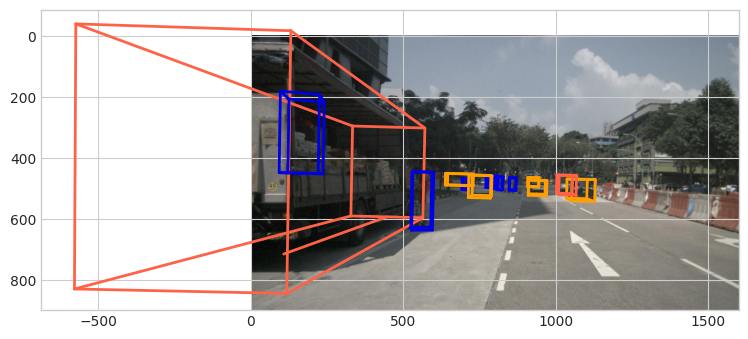

In [16]:
img_path, boxes_cam, camera_intrinsic = nusc.get_sample_data(samp['data'][refcam])
# read image
img = Image.open(img_path)
# Init axes
_, ax = plt.subplots(1, 1, figsize=(9, 16))
# Plot image
ax.imshow(img)

# This should now resides under camera coordinate
for box in boxes_ego:
    box.translate(-np.array(refcam_calib['translation']))
    box.rotate(Quaternion(refcam_calib['rotation']).inverse)
    if box.center[2]<=1 or abs(box.center[0])>=10 or not(box.name.startswith('human') or box.name.startswith('vehicle')):
        continue
    c = np.array(nusc.explorer.get_color(box.name)) / 255.0
    box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

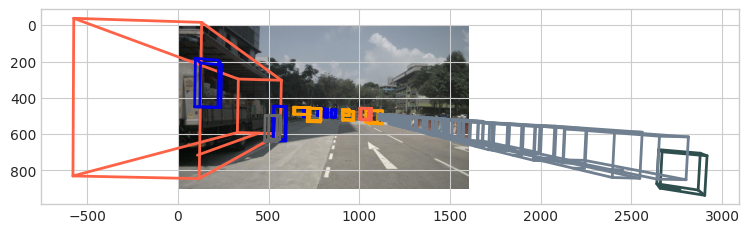

In [146]:
samp = nusc.sample[1]

# EXTRINSIC
lid_rec = nusc.get('sample_data', samp['data']['LIDAR_TOP'])
lid_egopose = nusc.get('ego_pose', lid_rec['ego_pose_token'])
lid_calib = nusc.get('calibrated_sensor', lid_rec['calibrated_sensor_token'])
cam_rec = nusc.get('sample_data', samp['data']['CAM_FRONT'])
cam_egopose = nusc.get('ego_pose', cam_rec['ego_pose_token'])
cam_calib = nusc.get('calibrated_sensor', cam_rec['calibrated_sensor_token'])
# INTRINSIC
img_path, boxes_cam, camera_intrinsic = nusc.get_sample_data(samp['data']['CAM_FRONT'])
# LIDAR 3DBBox
pc_path, boxes_lid, _ = nusc.get_sample_data(samp['data']['LIDAR_TOP'])


# read image
img = Image.open(img_path)
# Init axes
_, ax = plt.subplots(1, 1, figsize=(9, 16))
# Plot image
ax.imshow(img)
# Present 3D BBoxes
for box in boxes_lid:
    # Points live in the lidar frame. So they need to be transformed via global to the image plane.
    # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', lid_rec['calibrated_sensor_token'])
    box.rotate(Quaternion(cs_record['rotation']))
    box.translate(np.array(cs_record['translation']))

    # Second step: transform from ego to the global frame.
    poserecord = nusc.get('ego_pose', lid_rec['ego_pose_token'])
    box.rotate(Quaternion(poserecord['rotation']))
    box.translate(np.array(poserecord['translation']))

    # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam_rec['ego_pose_token'])
    box.translate(-np.array(poserecord['translation']))
    box.rotate(Quaternion(poserecord['rotation']).inverse)

    # Fourth step: transform from ego into the camera.
    cs_record = nusc.get('calibrated_sensor', cam_rec['calibrated_sensor_token'])
    box.translate(-np.array(cs_record['translation']))
    box.rotate(Quaternion(cs_record['rotation']).inverse)

    # This should now resides under camera coordinate
    if box.center[2]<=0 or abs(box.center[0])>=10:
        continue
    c = np.array(nusc.explorer.get_color(box.name)) / 255.0
    box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))




In [53]:
samp = nusc.sample[10]

# EXTRINSIC
lid_rec = nusc.get('sample_data', samp['data']['LIDAR_TOP'])
lid_egopose = nusc.get('ego_pose', lid_rec['ego_pose_token'])
lid_calib = nusc.get('calibrated_sensor', lid_rec['calibrated_sensor_token'])
refcam = 'CAM_FRONT'
cam_rec = nusc.get('sample_data', samp['data'][refcam])
cam_egopose = nusc.get('ego_pose', cam_rec['ego_pose_token'])
cam_calib = nusc.get('calibrated_sensor', cam_rec['calibrated_sensor_token'])

# get bev 3D bbox
imgs, img_metas, boxes_ego, intrins, extrins = nusc_bev.get_bev_bbox(3)
# BEV projection & visulization (For training purpose, we need a 1-dim vector here as target supervision)
img = np.zeros((320,200))
for ii, box in enumerate(boxes_ego):
    
    # box.translate(-np.array(cam_calib['translation']))
    # box.rotate(Quaternion(cam_calib['rotation']).inverse)
    # NuScenes filter
    if 'vehicle' not in box.name:
        continue
    if discard_invisible and int(inst['visibility_token']) == 1:
        # filter invisible vehicles
        continue
    # break
    pts = box.bottom_corners()[::2].T
    print('Bottom points under Ego vehicle coordinate: ', pts)
    # break
    mesh_xy = np.array([0.5, 0.25])
    min_xy = np.array([-80., -25.])
    pts_nr = (pts - min_xy) / mesh_xy
    pts = np.round(pts_nr).astype(np.int32)
    print('No-rounded points: ', pts_nr)
    print('Rounded Points: ', pts)
    pts[:, [1, 0]] = pts[:, [0, 1]]
    img = cv2.fillPoly(img, [pts], ii+1.0)
    # pts = np.round((pts-))

Bottom points under Ego vehicle coordinate:  [[ 5.25030166e+01 -1.26337248e-02]
 [ 5.04977582e+01 -4.07409261e-02]
 [ 5.01553091e+01 -1.34973353e-01]
 [ 5.21605676e+01 -1.06866151e-01]]
No-rounded points:  [[265.00603321  99.9494651 ]
 [260.99551632  99.8370363 ]
 [260.31061823  99.46010659]
 [264.32113512  99.57253539]]
Rounded Points:  [[265 100]
 [261 100]
 [260  99]
 [264 100]]
Bottom points under Ego vehicle coordinate:  [[48.40460821  0.40391806]
 [47.72128607  0.39167782]
 [47.94639644  0.36135772]
 [48.62971858  0.37359796]]
No-rounded points:  [[256.80921642 101.61567224]
 [255.44257215 101.56671129]
 [255.89279288 101.44543089]
 [257.25943715 101.49439185]]
Rounded Points:  [[257 102]
 [255 102]
 [256 101]
 [257 101]]
Bottom points under Ego vehicle coordinate:  [[69.19825472  2.03169268]
 [71.6984183   2.06656446]
 [72.19822257  2.1981145 ]
 [69.69805898  2.16324271]]
No-rounded points:  [[298.39650943 108.1267707 ]
 [303.3968366  108.26625786]
 [304.39644513 108.79245799]
 

In [55]:
pts

array([[102, 280],
       [102, 276],
       [102, 275],
       [102, 279]], dtype=int32)

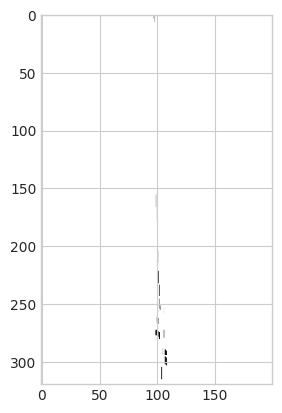

In [54]:
plt.imshow(img)

In [42]:
pts

array([[102, 280],
       [102, 276],
       [102, 275],
       [102, 279]], dtype=int32)

In [148]:
img = np.zeros((320,200))
pts = np.array([[50,100],[50,200],[300,200],[300,100]]).astype(np.int32)
pts[:, [1, 0]] = pts[:, [0, 1]]
# pts[:,1] = 300 - pts[:,1]

img = cv2.fillPoly(img, [pts], 1.)

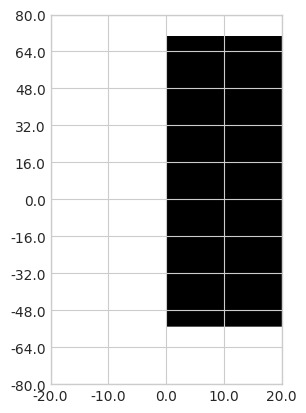

In [149]:
plt.imshow(img)
plt.ylim(0,320)
plt.xlim(0,200)
# reset y ticks (X coord in Ego coord)
locs = np.linspace(0, 320, 11)
comp_labels = (locs - 160) * mesh_xy[0]
_,_ = plt.yticks(locs, comp_labels)
# reset x ticks (Y coord in Ego coord)
locs = np.linspace(0,200,5)
comp_labels = (locs.astype(np.int32) - 100) * 0.2
_,_ = plt.xticks(locs, comp_labels)

In [118]:
comp_labels

array([-25.  , -18.75, -12.5 ,  -6.25,   0.  ,   6.25,  12.5 ,  18.75,
        25.  ])

In [127]:
(locs - 100) * 0.2

array([-20., -15., -10.,  -5.,   0.,   5.,  10.,  15.,  20.])

In [75]:
labels[0].get_text()

'0'

In [34]:
pts[:,[1,0]] = pts[:,[0,1]]

In [35]:
pts

array([[161, 170],
       [161, 166],
       [161, 165],
       [161, 169]], dtype=int32)

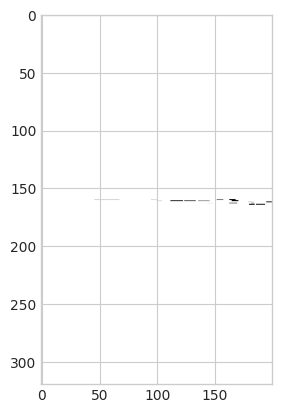

In [31]:
plt.imshow(img)

In [28]:
pts = box.bottom_corners()[:2].T
mesh_xy = np.array([0.5, 0.25])
min_xy = np.array([-80., -25.])
pts_nr = (pts - min_xy) / mesh_xy
pts = np.round(pts_nr).astype(np.int32)


array([[265, -45],
       [261, -45],
       [260, -63],
       [264, -64]], dtype=int32)

In [29]:
abs(min_xy * 2) / mesh_xy

array([320., 200.])

In [245]:
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [226]:
box.bottom_corners()[:2].T

array([[ 59.77405025, -27.25498577],
       [ 57.90161952, -27.16068275],
       [ 57.68346387, -31.51735164],
       [ 59.5558946 , -31.61165466]])

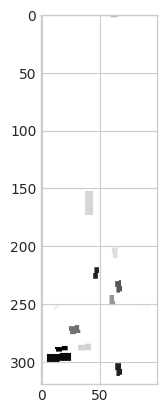

In [18]:
plt.imshow(img)

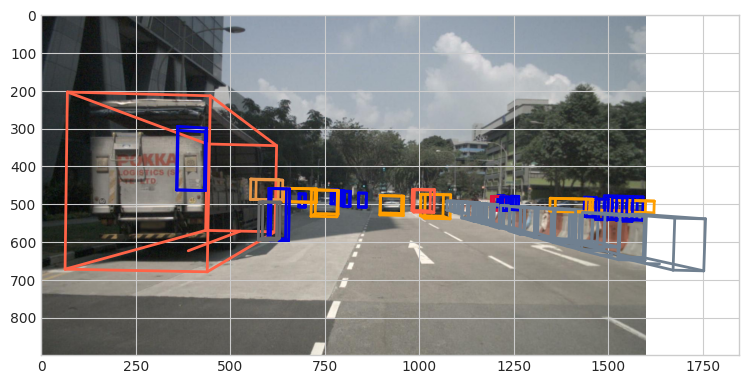

In [18]:
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from PIL import Image
import numpy as np

samp = nusc.sample[0]
sample_data_token = samp['data']['CAM_FRONT']
box_vis_level = BoxVisibility.ANY
# Load boxes and image.
data_path, boxes, camera_intrinsic = nusc.get_sample_data(sample_data_token,
                                                               box_vis_level=box_vis_level)
data = Image.open(data_path)
# Init axes
_, ax = plt.subplots(1, 1, figsize=(9, 16))
# Plot image
ax.imshow(data)
# present 3D anno bboxes
for box in boxes:
    c = np.array(nusc.explorer.get_color(box.name)) / 255.0
    box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

In [20]:
rec = nusc.sample[0]
egopose = nusc.get('ego_pose', nusc.get('sample_data', rec['data']['LIDAR_TOP'])['ego_pose_token'])
trans = np.array(egopose['translation'])
rot = Quaternion(egopose['rotation']).inverse
# LRT
# Box
# Vis
# Tid
# Dim + Bbox center & orientation info under world coordinate
lrtlist = []
# Ceter, Dim & only one yaw information of 3D Bbox -- as if pitch & roll do 
# not matter, only yaw is considered, boxlist is a rounded version of BBox3D
boxlist = []
# visibility level
vislist = []
# some token is stored here ??instance token?
tidlist = []
    
for tok in rec['anns']:
    inst = nusc.get('sample_annotation', tok)
    # NuScenes filter
    if 'vehicle' not in inst['category_name']:
        continue
    if int(inst['visibility_token']) == 1:
        vislist.append(torch.tensor(0.0)) # invisible
    else:
        vislist.append(torch.tensor(1.0)) # visible
    
    box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
    box.translate(trans)
    box.rotate(rot)

    tidlist.append(inst['instance_token'])
    # At this time, the translation & rotation is under the world coordinate
    # and not just under the lidar coordinate system
    r = box.rotation_matrix
    t = box.center
    l = box.wlh
    # change of order slightly
    l = np.stack([l[1],l[0],l[2]])
    # Dim Bbox + Rotation + Translation (Center) under world coordinate system
    lrt = utils.py.merge_lrt(l, utils.py.merge_rt(r,t))
    lrt = torch.Tensor(lrt)
    lrtlist.append(lrt)
    ry, _, _ = Quaternion(inst['rotation']).yaw_pitch_roll
    # print('rx, ry, rz', rx, ry, rz)
    rs = np.stack([ry*0, ry, ry*0])
    box_ = torch.from_numpy(np.stack([t,l,rs])).reshape(9)
    # print('box_', box_)
    boxlist.append(box_)

* get bev segmentation function?
* LRTlist_cam is not the lrtlist obtained from the above kernel
* One hint and trace of proof is inside the VisData class:

In [100]:
print('This is how they Get the LRTlist')
egopose = nusc.get('ego_pose', nusc.get('sample_data', rec['data']['LIDAR_TOP'])['ego_pose_token'])
trans = np.array(egopose['translation'])
rot = Quaternion(egopose['rotation']).inverse
lrtlist = []
boxlist = []
vislist = []
tidlist = []
for tok in rec['anns']:
    inst = nusc.get('sample_annotation', tok)
    if 'vehicle' not in inst['category_name']:
        continue
    if int(inst['visibility_token']) == 1:
        vislist.append(torch.tensor(0.0)) # invisible
    else:
        vislist.append(torch.tensor(1.0)) # visible
    print('Note tha the sample_annotation bbox is actually given under the global coordinate')
    print('The Extra Translation & Rotation are actually used to convert the 3D box annotaation Back onto Lidar Coordinate')
    print('It is use to convert Back from Global coordinate, not Towards Global coordinate ! \n')
    box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
    box.translate(trans)
    box.rotate(rot)
    tidlist.append(inst['instance_token'])
    # I simply bet the bbox now is given under Liar Top coordinate 
    r = box.rotation_matrix
    t = box.center
    l = box.wlh
    l = np.stack([l[1], l[0], l[2]])
    print('LRT List: Dimension 3 values, Rotation and Translation -> Transformation matrix')
    lrt = utils.py.merge_lrt(l, utils.py.merge_rt(r,t))
    lrt = torch.Tensor(lrt)
    lrtlist.append(lrt)
    ry, _, _ = Quaternion(inst['rotation']).yaw_pitch_roll
    rs = np.stack([ry*0, ry, ry*0])
    box_ = torch.from_numpy(np.stack([t,l,rs])).reshape(9)
    boxlist.append(box_)
if len(lrtlist):
    lrtlist = torch.stack(lrtlist, dim=0)
    boxlist = torch.stack(boxlist, dim=0)
    vislist = torch.stack(vislist, dim=0)
print('Annotated 3DBox is further converted with Egopose roation & translation')
print('Resulted Box rotation / orientation matrix & Center / translation is recorded, together with Dimension Information into so-callsed LRT list')
print('Then clearly such LRT list is use for supervision as GT')
print('The question is what does it relate to the other coordinate system, other camera system and so on?')

This is how they Get the LRTlist
Note tha the sample_annotation bbox is actually given under the global coordinate
The Extra Translation & Rotation are actually used to convert the 3D box annotaation Back onto Lidar Coordinate
It is use to convert Back from Global coordinate, not Towards Global coordinate ! 

LRT List: Dimension 3 values, Rotation and Translation -> Transformation matrix
Note tha the sample_annotation bbox is actually given under the global coordinate
The Extra Translation & Rotation are actually used to convert the 3D box annotaation Back onto Lidar Coordinate
It is use to convert Back from Global coordinate, not Towards Global coordinate ! 

LRT List: Dimension 3 values, Rotation and Translation -> Transformation matrix
Note tha the sample_annotation bbox is actually given under the global coordinate
The Extra Translation & Rotation are actually used to convert the 3D box annotaation Back onto Lidar Coordinate
It is use to convert Back from Global coordinate, not Tow

In [156]:
print('Note:') 
print('Q: Figure out the Extrinsic for LidarTop and convert 3DBbox towards all camera coordinates')

Note:
Q: Figure out the Extrinsic for LidarTop and convert 3DBbox towards all camera coordinates


In [18]:
egopose

{'token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'timestamp': 1532402927647951,
 'rotation': [0.5720320396729045,
  -0.0016977771610471074,
  0.011798001930183783,
  -0.8201446642457809],
 'translation': [411.3039349319818, 1180.8903791765097, 0.0]}

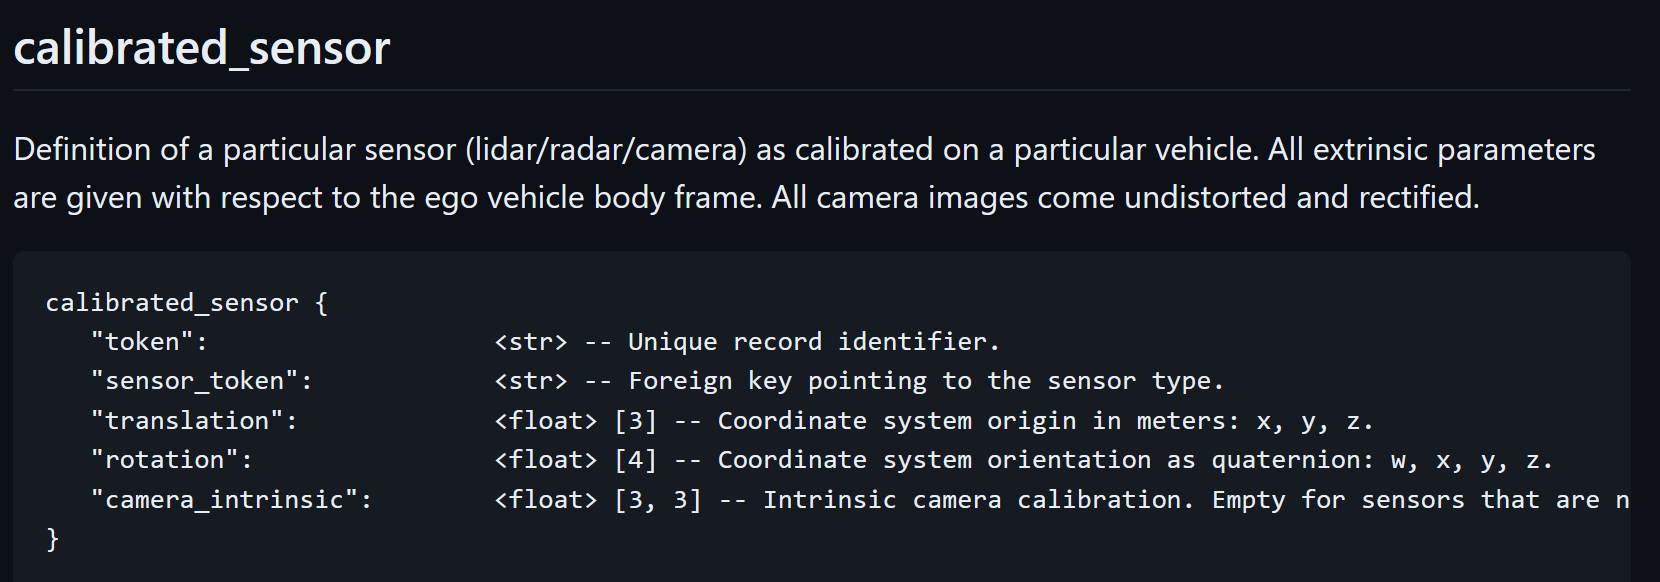

In [24]:
lrtlist_, boxlist_, vislist_, tidlist_ = nusc_data.get_lrtlist(rec)
N_ = lrtlist_.shape[0]

# import ipdb; ipdb.set_trace()
if N_ > 0:
    # ksgk: combine rotation & translation like mine
    print('I think here is a BUG where it actually computes Cam_T_Velo, not the other way around!?')
    print('The idea is Velo_T_Cam @ Cam_xyz = Velo_xyz || Cam_T_Velo @ Velo_xyz = Cam_xyz')
    velo_T_cam = utils.geom.merge_rt(rots, trans)
    # inverse on the 4x4 c2v matrix, note the name velo is used
    cam_T_velo = utils.geom.safe_inverse(velo_T_cam)
    # note we index 0:1, since we already put refcam into zeroth position
    # Then we are just using the Front Camera Extrinsic, plus the usage here means cam_T_velo is v2c transformation matrix
    print('For this transofrmaiton to be valid, the lrtlist_ needs to reside under the car-coordinate, front x left y coordinate')
    lrtlist_cam = utils.geom.apply_4x4_to_lrt(cam_T_velo[0:1].repeat(N_, 1, 1), lrtlist_).unsqueeze(0)
    # seg_bev, valid_bev = nusc_data.get_seg_bev(lrtlist_cam, vislist_)
    # center_bev, offset_bev, size_bev, ry_bev, ycoord_bev = nusc_data.get_center_and_offset_bev(lrtlist_cam, seg_bev)

I think here is a BUG where it actually computes Cam_T_Velo, not the other way around!?
The idea is Velo_T_Cam @ Cam_xyz = Velo_xyz || Cam_T_Velo @ Velo_xyz = Cam_xyz
For this transofrmaiton to be valid, the lrtlist_ needs to reside under the car-coordinate, front x left y coordinate


$R  \times X + T = Y$

$R^{T} \times (Y - T) = X$

In [144]:
lrtlist.shape

torch.Size([13, 19])

In [26]:
from utils.geom import *
print('Re-implementation of Apply 4x4 to lrt function: ')
Y_T_X = cam_T_velo[:1].repeat(N_, 1, 1)
lrt_X = lrtlist_

B, D = list(lrt_X.shape)
assert(D==19)
B2, E, F = list(Y_T_X.shape)
assert(B2 == B)
assert(E==4 and F==4)

lrtlist_X = lrt_X.unsqueeze(1)
print('Besides so many dimension judgetment lines, it mostly just cut on the last dimension and do reshhape her')
lenlist, rtlist_X = split_lrtlist(lrtlist_X)

B,N,D = list(lrtlist_X.shape)
Y_T_Xs = Y_T_X.unsqueeze(1).repeat(1, N, 1, 1)
Y_T_Xs_ = Y_T_Xs.view(B*N, 4, 4)
rtlist_X_ = rtlist_X.reshape(B*N, 4, 4)
rtlist_Y_ = utils.basic.matmul2(Y_T_Xs_, rtlist_X_)
rtlist_Y = rtlist_Y_.reshape(B, N, 4, 4)
lrtlist_Y = merge_lrtlist(lenlist, rtlist_Y)

lrtlist_cam_ksgk = lrtlist_Y.squeeze(1).unsqueeze(0)

Re-implementation of Apply 4x4 to lrt function: 
Besides so many dimension judgetment lines, it mostly just cut on the last dimension and do reshhape her


In [92]:
def split_lrtlist(lrtlist):
    # splits a B x N x 19 tensor
    # into B x N x 3 (lens)
    # and B x N x 4 x 4 (rts)
    B, N, D = list(lrtlist.shape)
    assert(D==19)
    lenlist = lrtlist[:,:,:3].reshape(B, N, 3)
    ref_T_objs_list = lrtlist[:,:,3:].reshape(B, N, 4, 4)
    return lenlist, ref_T_objs_list

def merge_lrtlist(lenlist, rtlist):
    # lenlist is B x N x 3
    # rtlist is B x N x 4 x 4
    # merges these into a B x N x 19 tensor
    B, N, D = list(lenlist.shape)
    assert(D==3)
    B2, N2, E, F = list(rtlist.shape)
    assert(B==B2)
    assert(N==N2)
    assert(E==4 and F==4)
    rtlist = rtlist.reshape(B, N, 16)
    lrtlist = torch.cat([lenlist, rtlist], axis=2)
    return lrtlist

def apply_4x4_to_lrtlist(Y_T_X, lrtlist_X):
    B, N, D = list(lrtlist_X.shape)
    assert(D==19)
    B2, E, F = list(Y_T_X.shape)
    assert(B2==B)
    assert(E==4 and F==4)

    lenlist, rtlist_X = split_lrtlist(lrtlist_X)

    Y_T_Xs = Y_T_X.unsqueeze(1).repeat(1, N, 1, 1)
    Y_T_Xs_ = Y_T_Xs.view(B*N, 4, 4)
    rtlist_X_ = rtlist_X.reshape(B*N, 4, 4)
    rtlist_Y_ = utils.basic.matmul2(Y_T_Xs_, rtlist_X_)
    rtlist_Y = rtlist_Y_.reshape(B, N, 4, 4)
    lrtlist_Y = merge_lrtlist(lenlist, rtlist_Y)
    return lrtlist_Y

def apply_4x4_to_lrt(Y_T_X, lrt_X):
    B, D = list(lrt_X.shape)
    assert(D==19)
    B2, E, F = list(Y_T_X.shape)
    assert(B2==B)
    assert(E==4 and F==4)

    return apply_4x4_to_lrtlist(Y_T_X, lrt_X.unsqueeze(1)).squeeze(1)

In [ ]:
lrtlist_, boxlist_, vislist_, tidlist_ = self.get_lrtlist(rec)

In [139]:
def get_single_item(self, index, cams, refcam_id=None):
    # print('index %d; cam_id' % index, cam_id)
    rec = self.ixes[index]

    imgs, rots, trans, intrins = self.get_image_data(rec, cams)
    lidar_data = self.get_lidar_data(rec, nsweeps=self.nsweeps)
    binimg, egopose = self.get_binimg(rec)

    if refcam_id is None:
        if self.is_train:
            # randomly sample the ref cam
            refcam_id = np.random.randint(1, len(cams))
        else:
            refcam_id = self.refcam_id

    # move the target refcam_id to the zeroth slot
    img_ref = imgs[refcam_id].clone()
    img_0 = imgs[0].clone()
    imgs[0] = img_ref
    imgs[refcam_id] = img_0

    rot_ref = rots[refcam_id].clone()
    rot_0 = rots[0].clone()
    rots[0] = rot_ref
    rots[refcam_id] = rot_0

    tra+n_ref = trans[refcam_id].clone()
    tran_0 = trans[0].clone()
    trans[0] = tran_ref
    trans[refcam_id] = tran_0

    intrin_ref = intrins[refcam_id].clone()
    intrin_0 = intrins[0].clone()
    intrins[0] = intrin_ref
    intrins[refcam_id] = intrin_0

    radar_data = self.get_radar_data(rec, nsweeps=self.nsweeps)

    lidar_extra = lidar_data[3:]
    lidar_data = lidar_data[:3]

    lrtlist_, boxlist_, vislist_, tidlist_ = self.get_lrtlist(rec)
    N_ = lrtlist_.shape[0]

    # import ipdb; ipdb.set_trace()
    if N_ > 0:
        # ksgk: combine rotation & translation like mine
        print('I think here is a BUG where it actually computes Cam_T_Velo, not the other way around!?')
        velo_T_cam = utils.geom.merge_rt(rots, trans)
        # inverse on the 4x4 c2v matrix, note the name velo is used
        cam_T_velo = utils.geom.safe_inverse(velo_T_cam)

        # note we index 0:1, since we already put refcam into zeroth position
        lrtlist_cam = utils.geom.apply_4x4_to_lrt(cam_T_velo[0:1].repeat(N_, 1, 1), lrtlist_).unsqueeze(0)

        seg_bev, valid_bev = self.get_seg_bev(lrtlist_cam, vislist_)

        center_bev, offset_bev, size_bev, ry_bev, ycoord_bev = self.get_center_and_offset_bev(lrtlist_cam, seg_bev)
    else:
        seg_bev = torch.zeros((1, self.Z, self.X), dtype=torch.float32)
        valid_bev = torch.ones((1, self.Z, self.X), dtype=torch.float32)
        center_bev = torch.zeros((1, self.Z, self.X), dtype=torch.float32)
        offset_bev = torch.zeros((2, self.Z, self.X), dtype=torch.float32)
        size_bev = torch.zeros((3, self.Z, self.X), dtype=torch.float32)
        ry_bev = torch.zeros((1, self.Z, self.X), dtype=torch.float32)
        ycoord_bev = torch.zeros((1, self.Z, self.X), dtype=torch.float32)


In [ ]:
def get_seg_bev(self, lrtlist_cam, vislist):
    B, N, D = lrtlist_cam.shape
    assert(B==1)

    seg = np.zeros((self.Z, self.X))
    val = np.ones((self.Z, self.X))

    corners_cam = utils.geom.get_xyzlist_from_lrtlist(lrtlist_cam) # B, N, 8, 3
    y_cam = corners_cam[:,:,:,1] # y part; B, N, 8
    corners_mem = self.vox_util.Ref2Mem(corners_cam.reshape(B, N*8, 3), self.Z, self.Y, self.X).reshape(B, N, 8, 3)

    # take the xz part
    corners_mem = torch.stack([corners_mem[:,:,:,0], corners_mem[:,:,:,2]], dim=3) # B, N, 8, 2
    # corners_mem = corners_mem[:,:,:4] # take the bottom four

    for n in range(N):
        _, inds = torch.topk(y_cam[0,n], 4, largest=False)
        pts = corners_mem[0,n,inds].numpy().astype(np.int32) # 4, 2

        # if this messes in some later conditions,
        # the solution is to draw all combos
        pts = np.stack([pts[0],pts[1],pts[3],pts[2]])

        # pts[:, [1, 0]] = pts[:, [0, 1]]
        cv2.fillPoly(seg, [pts], n+1.0)

        if vislist[n]==0:
            # draw a black rectangle if it's invisible
            cv2.fillPoly(val, [pts], 0.0)

    return torch.Tensor(seg).unsqueeze(0), torch.Tensor(val).unsqueeze(0) # 1, Z, X

* I know how to get all the images from 6 cameras
* 3D Bbox annotation on each camera coordinate is also provided here
* Missing: Lidar coordiante 3D Bbox annotation / world coordinate location with egopose?

Inside the boxes are a list of Box object, which corresponds to 3D Bbox annotation, with center & size & orientation


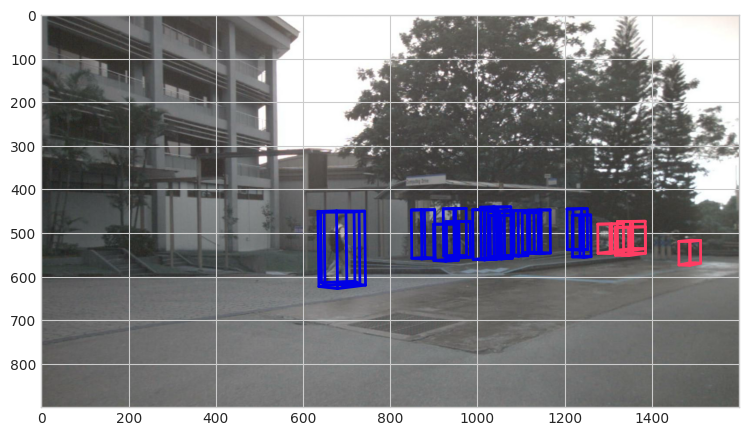

In [14]:
samp = nusc.sample[244]
sensor_tok = samp['data']['CAM_FRONT']
box_vis_level = BoxVisibility.ANY
print('Inside the boxes are a list of Box object, which corresponds to 3D Bbox annotation, with center & size & orientation')
img_path, boxes, camera_intrinsic = nusc.get_sample_data(sensor_tok, box_vis_level)
img = cv2.imread(img_path)
_, ax = plt.subplots(1,1,figsize=(9,16))
ax.imshow(img)
for box in boxes:
    c = np.array(nusc.explorer.get_color(box.name)) / 255.0
    box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

In [18]:
sensor_tok = samp['data']['LIDAR_TOP']
pcd_path, boxes, ww = nusc.get_sample_data(sensor_tok)
print('Q: But, how does the Lidar coordinate transform onto each camera?')

Q: But, how does the Lidar coordinate transform onto each camera?


In [16]:
boxes[0]

label: nan, score: nan, xyz: [18.41, 59.52, 0.77], wlh: [0.62, 0.67, 1.64], rot axis: [0.01, -0.02, 1.00], ang(degrees): 179.02, ang(rad): 3.12, vel: nan, nan, nan, name: human.pedestrian.adult, token: ef63a697930c4b20a6b9791f423351da

In [8]:
nusc.get_sample_data(sensor_tok)

('/mnt/d/Data/NuScene-mini/samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402927647951.pcd.bin',
 [label: nan, score: nan, xyz: [18.41, 59.52, 0.77], wlh: [0.62, 0.67, 1.64], rot axis: [0.01, -0.02, 1.00], ang(degrees): 179.02, ang(rad): 3.12, vel: nan, nan, nan, name: human.pedestrian.adult, token: ef63a697930c4b20a6b9791f423351da,
  label: nan, score: nan, xyz: [21.00, 36.06, -0.03], wlh: [0.78, 0.77, 1.71], rot axis: [-0.03, 0.01, -1.00], ang(degrees): -87.24, ang(rad): -1.52, vel: nan, nan, nan, name: human.pedestrian.adult, token: 6b89da9bf1f84fd6a5fbe1c3b236f809,
  label: nan, score: nan, xyz: [37.35, 64.40, 0.45], wlh: [2.01, 4.63, 1.57], rot axis: [0.01, -0.02, 1.00], ang(degrees): 176.99, ang(rad): 3.09, vel: nan, nan, nan, name: vehicle.car, token: 924ee6ac1fed440a9d9e3720aac635a0,
  label: nan, score: nan, xyz: [25.37, 32.17, -0.16], wlh: [0.75, 0.82, 1.64], rot axis: [-0.01, -0.02, 1.00], ang(degrees): -95.14, ang(rad): -1.66, vel: nan, nan, nan, name: huma

* Get binimg : Not sure what this function is doing -- it seems to translate & rotate on the lidar annotated bbox with egopose information

In [59]:
rec = nusc.sample[402]
rec = nusc.sample[10]


egopose = nusc.get('ego_pose', nusc.get('sample_data', rec['data']['LIDAR_TOP'])['ego_pose_token'])
trans = -np.array(egopose['translation'])
rot = Quaternion(egopose['rotation']).inverse
img = np.zeros((nusc_data.nx[0], nusc_data.nx[1]))

for ii, tok in enumerate(rec['anns']):
    inst = nusc.get('sample_annotation', tok)
    # NuScenes filter
    if 'vehicle' not in inst['category_name']:
        continue
    if discard_invisible and int(inst['visibility_token']) == 1:
        # filter invisible vehicles
        continue
    box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
    box.translate(trans)
    box.rotate(rot)

    pts = box.bottom_corners()[:2].T
    pts = np.round(
        (pts - nusc_data.bx[:2] + nusc_data.dx[:2]/2.) / nusc_data.dx[:2]
        ).astype(np.int32)
    pts[:, [1, 0]] = pts[:, [0, 1]]
    cv2.fillPoly(img, [pts], ii+1.0)
    break

In [64]:
box

label: nan, score: nan, xyz: [23.97, -40.09, 0.42], wlh: [2.01, 4.63, 1.57], rot axis: [0.00, -0.01, 1.00], ang(degrees): 82.78, ang(rad): 1.44, vel: nan, nan, nan, name: None, token: None

Inside the boxes are a list of Box object, which corresponds to 3D Bbox annotation, with center & size & orientation


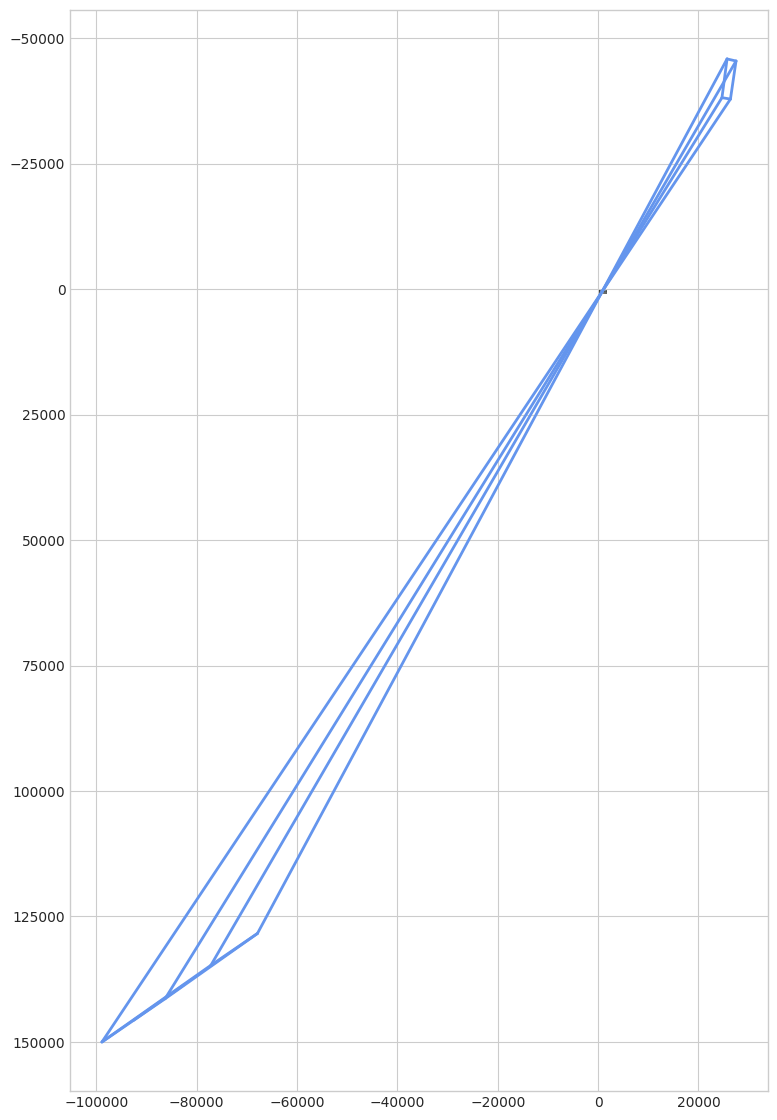

In [66]:
sensor_tok = rec['data']['CAM_FRONT']
box_vis_level = BoxVisibility.ANY
print('Inside the boxes are a list of Box object, which corresponds to 3D Bbox annotation, with center & size & orientation')
img_path, boxes, camera_intrinsic = nusc.get_sample_data(sensor_tok, box_vis_level)
img = cv2.imread(img_path)
_, ax = plt.subplots(1,1,figsize=(9,16))
ax.imshow(img)

c = np.array(nusc.explorer.get_color(boxes[0].name)) / 255.0
box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

In [61]:
inst

{'token': '31ff0a4b0de44ce8854c919ff45a3fdc',
 'sample_token': '023c4df2d451409881d8e6ea82f14704',
 'instance_token': 'bd26c2cdb22d4bb1834e808c89128898',
 'visibility_token': '3',
 'attribute_tokens': ['c3246a1e22a14fcb878aa61e69ae3329'],
 'translation': [353.911, 1132.305, 0.802],
 'size': [2.011, 4.633, 1.573],
 'rotation': [0.9797276292877292, 0.0, 0.0, -0.20033415188191459],
 'prev': '2e26ff64232f4fa2b5d15f606a9006cf',
 'next': 'a527efcb99404315bf821a40236dd0a8',
 'num_lidar_pts': 10,
 'num_radar_pts': 0,
 'category_name': 'vehicle.car'}

In [60]:
img.shape

(1, 1)

In [55]:
nusc_data.get_binimg(rec)

(tensor([[[0.]]]),
 tensor([[-2.7380e-01,  9.6170e-01,  1.2480e-02,  3.9902e+02],
         [-9.6173e-01, -2.7362e-01, -1.4702e-02,  1.1444e+03],
         [-1.0724e-02, -1.6028e-02,  9.9981e-01,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]))

In [26]:
nusc.get('sample_data', samp_rec['data']['CAM_FRONT'])

{'token': 'e3d495d4ac534d54b321f50006683844',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402927612460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg',
 'prev': '',
 'next': '68e8e98cf7b0487baa139df808641db7',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

In [57]:
corners_tran.shape

(3, 8)

In [61]:
rot_lid.rotation_matrix

array([[-0.34555293, -0.93833811, -0.01071282],
       [ 0.93825799, -0.34528031, -0.0212945 ],
       [ 0.01628252, -0.01740977,  0.99971585]])

In [76]:
corners_orig.T

array([[ 3.73679825e+02,  1.13058833e+03,  1.62100000e+00],
       [ 3.73456358e+02,  1.13000893e+03,  1.62100000e+00],
       [ 3.73456358e+02,  1.13000893e+03, -2.10000000e-02],
       [ 3.73679825e+02,  1.13058833e+03, -2.10000000e-02],
       [ 3.73055642e+02,  1.13082907e+03,  1.62100000e+00],
       [ 3.72832175e+02,  1.13024967e+03,  1.62100000e+00],
       [ 3.72832175e+02,  1.13024967e+03, -2.10000000e-02],
       [ 3.73055642e+02,  1.13082907e+03, -2.10000000e-02]])

In [ ]:
box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
box.translate(inst['translation'])

In [85]:
print('Rotation matrix is ok, but why is the translation matrix given in Negative sign????')
(np.linalg.inv(Quaternion(egopos_lid['rotation']).rotation_matrix) @ (corners_orig + np.array(egopos_lid['translation'])[:,None])).T

Rotation matrix is ok, but why is the translation matrix given in Negative sign????


array([[-2440.21936623,   -61.62530838,   -25.84026452],
       [-2439.59847415,   -61.63492294,   -25.83381592],
       [-2439.5808837 ,   -61.59995736,   -27.47534934],
       [-2440.20177578,   -61.59034281,   -27.48179794],
       [-2440.22957307,   -62.29407648,   -25.85461903],
       [-2439.60868099,   -62.30369104,   -25.84817042],
       [-2439.59109053,   -62.26872546,   -27.48970385],
       [-2440.21198261,   -62.25911091,   -27.49615245]])

In [79]:
# Anns annotation 3D box given under 
box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
print('Original Box corners: ')
corners_orig = box.corners()
print(corners_orig.T)

trans_lid = egopos_lid['translation']
rot_lid = Quaternion(egopos_lid['rotation']).inverse
box.translate(trans_lid)
box.rotate(rot_lid)

corners_tran = box.corners()
print('After Transformation Box corners: ')
print(corners_tran.T)

# get corners
w,l,h = box.wlh

# 3D bounding box corners. (Convention: x points forward, y to the left, z up.)
x_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
y_corners = w / 2 * np.array([1, -1, -1,  1,  1, -1, -1,  1])
z_corners = h / 2 * np.array([1,  1, -1, -1,  1,  1, -1, -1])
corners = np.vstack((x_corners, y_corners, z_corners))

# Rotate
corners = np.dot(box.orientation.rotation_matrix, corners)

# Translate
x, y, z = box.center
corners[0, :] = corners[0, :] + x
corners[1, :] = corners[1, :] + y
corners[2, :] = corners[2, :] + z

Original Box corners: 
[[ 3.73679825e+02  1.13058833e+03  1.62100000e+00]
 [ 3.73456358e+02  1.13000893e+03  1.62100000e+00]
 [ 3.73456358e+02  1.13000893e+03 -2.10000000e-02]
 [ 3.73679825e+02  1.13058833e+03 -2.10000000e-02]
 [ 3.73055642e+02  1.13082907e+03  1.62100000e+00]
 [ 3.72832175e+02  1.13024967e+03  1.62100000e+00]
 [ 3.72832175e+02  1.13024967e+03 -2.10000000e-02]
 [ 3.73055642e+02  1.13082907e+03 -2.10000000e-02]]
After Transformation Box corners: 
[[-2440.21936623   -61.62530838   -25.84026452]
 [-2439.59847415   -61.63492294   -25.83381592]
 [-2439.5808837    -61.59995736   -27.47534934]
 [-2440.20177578   -61.59034281   -27.48179794]
 [-2440.22957307   -62.29407648   -25.85461903]
 [-2439.60868099   -62.30369104   -25.84817042]
 [-2439.59109053   -62.26872546   -27.48970385]
 [-2440.21198261   -62.25911091   -27.49615245]]


In [33]:
def translate(self, x: np.ndarray) -> None:
    """
    Applies a translation.
    :param x: <np.float: 3, 1>. Translation in x, y, z direction.
    """
    self.center += x

# The rotation matrix is a bit interesting here: may
def rotate(self, quaternion: Quaternion) -> None:
    """
    Rotates box.
    :param quaternion: Rotation to apply.
    """
    self.center = np.dot(quaternion.rotation_matrix, self.center)
    self.orientation = quaternion * self.orientation
    self.velocity = np.dot(quaternion.rotation_matrix, self.velocity)

def corners(self, wlh_factor: float = 1.0) -> np.ndarray:
    """
    Returns the bounding box corners.
    :param wlh_factor: Multiply w, l, h by a factor to scale the box.
    :return: <np.float: 3, 8>. First four corners are the ones facing forward.
        The last four are the ones facing backwards.
    """
    w, l, h = self.wlh * wlh_factor

    # 3D bounding box corners. (Convention: x points forward, y to the left, z up.)
    x_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
    y_corners = w / 2 * np.array([1, -1, -1,  1,  1, -1, -1,  1])
    z_corners = h / 2 * np.array([1,  1, -1, -1,  1,  1, -1, -1])
    corners = np.vstack((x_corners, y_corners, z_corners))

    # Rotate
    corners = np.dot(self.orientation.rotation_matrix, corners)

    # Translate
    x, y, z = self.center
    corners[0, :] = corners[0, :] + x
    corners[1, :] = corners[1, :] + y
    corners[2, :] = corners[2, :] + z

    return corners

def bottom_corners(self) -> np.ndarray:
    """
    Returns the four bottom corners.
    :return: <np.float: 3, 4>. Bottom corners. First two face forward, last two face backwards.
    """
    return self.corners()[:, [2, 3, 7, 6]]

nuscenes.utils.data_classes.Box

In [32]:
samp_rec = nusc.sample[0]
lid_data = nusc.get('sample_data', samp_rec['data']['LIDAR_TOP'])
egopos_lid = nusc.get('ego_pose', lid_data['ego_pose_token'])
calib_lid = nusc.get('calibrated_sensor', lid_data['calibrated_sensor_token'])

trans_lid = egopos_lid['translation']
rot_lid = Quaternion(egopos_lid['rotation']).inverse

anns_tok = samp_rec['anns'][0]
inst = nusc.get('sample_annotation', anns_tok)
if 'vehicle' not in inst['category_name']:
    print('Non-vehicle objects')
# This transformation seems to have converted 3DBBOX from global towards ego-car coordinate, at the specific timestamp 
# where the timestamp is decided by the LidarTop, as the 3DBox is obvisouly inferenced out from the LIDAR detector
box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
box.translate(trans_lid)
box.rotate(rot_lid)


cam_data = nusc.get('sample_data', samp_rec['data']['CAM_FRONT'])
egopose_cam = nusc.get('ego_pose', cam_data['ego_pose_token'])
calib_cam = nusc.get('calibrated_sensor', cam_data['calibrated_sensor_token'])


img_path, boxes, camera_intrinsic = nusc.get_sample_data(samp_rec['data']['CAM_FRONT'], BoxVisibility.ANY)

sensor_tok = rec['data']['CAM_FRONT']
box_vis_level = BoxVisibility.ANY
print('Inside the boxes are a list of Box object, which corresponds to 3D Bbox annotation, with center & size & orientation')
img_path, boxes, camera_intrinsic = nusc.get_sample_data(sensor_tok, box_vis_level)

# img = cv2.imread(img_path)
# _, ax = plt.subplots(1,1,figsize=(9,16))
# ax.imshow(img)

# c = np.array(nusc.explorer.get_color(boxes[0].name)) / 255.0
# box.render(ax, view=camera_intrinsic, normalize=True, colors=(c, c, c))

Non-vehicle objects
Inside the boxes are a list of Box object, which corresponds to 3D Bbox annotation, with center & size & orientation


In [87]:
pose_rec

{'token': '9d9bf11fb0e144c8b446d54a8a00184f',
 'timestamp': 1532402927647951,
 'rotation': [0.5720320396729045,
  -0.0016977771610471074,
  0.011798001930183783,
  -0.8201446642457809],
 'translation': [411.3039349319818, 1180.8903791765097, 0.0]}

In [92]:
car2glob = transform_matrix(pose_rec['translation'], Quaternion(pose_rec['rotation']), inverse=False)
glob2car = transform_matrix(pose_rec['translation'], Quaternion(pose_rec['rotation']), inverse=True)
car2glob[:3,3]

array([ 411.30393493, 1180.89037918,    0.        ])

In [93]:
car2glob

array([[-3.45552926e-01,  9.38257989e-01,  1.62825160e-02,
         4.11303935e+02],
       [-9.38338111e-01, -3.45280305e-01, -1.74097708e-02,
         1.18089038e+03],
       [-1.07128245e-02, -2.12945025e-02,  9.99715849e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [86]:
all_samples = nusc.sample
samp_rec = all_samples[0]

lid_tok = samp_rec['data']['LIDAR_TOP']
lid_rec = nusc.get('sample_data', lid_tok)
pose_rec = nusc.get('ego_pose', lid_rec['ego_pose_token'])
cs_rec = nusc.get('calibrated_sensor', sd_rec['calibrated_sensor_token'])
ref_time = 1e-6 * sd_rec['timestamp']

car2glob = transform_matrix(pose_rec['translation'], Quaternion(pose_rec['rotation']), inverse=False)
glob2car = transform_matrix(pose_rec['translation'], Quaternion(pose_rec['rotation']), inverse=True)

car2sen = transform_matrix(cs_rec['translation'], Quaternion(cs_rec['rotation']), inverse=False)
sen2car = transform_matrix(cs_rec['translation'], Quaternion(cs_rec['rotation']), inverse=True)

# Point Cloud for Current Sample Data
current_pc = LidarPointCloud.from_file(os.path.join(nusc.dataroot, sd_rec['filename']))
# transform PC under LIDAR TOP sensor towards ego car coordinate
current_pc.transform(sen2car)

# LRT LIST preparation
trans = np.array(pose_rec['translation'])
rot = Quaternion(pose_rec['rotation']).inverse

for anns_tok in samp_rec['anns']:
    inst = nusc.get('sample_annotation', anns_tok)
    if 'vehicle' not in inst['category_name']:
        # print('Non-interesting object')
        continue
    else:
        print('Interesting object')
        break

box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))

box.translate(trans)
box.rotate(rot)

NameError: name 'sd_rec' is not defined

In [7]:
def get_binimg(self, rec):
    egopose = self.nusc.get('ego_pose', self.nusc.get('sample_data', rec['data']['LIDAR_TOP'])['ego_pose_token'])
    trans = -np.array(egopose['translation'])
    rot = Quaternion(egopose['rotation']).inverse
    img = np.zeros((self.nx[0], self.nx[1]))
    for ii, tok in enumerate(rec['anns']):
        inst = self.nusc.get('sample_annotation', tok)

        if not self.is_lyft:
            # NuScenes filter
            if 'vehicle' not in inst['category_name']:
                continue
            if discard_invisible and int(inst['visibility_token']) == 1:
                # filter invisible vehicles
                continue
        else:
            # Lyft filter
            if inst['category_name'] not in ['bus', 'car', 'construction_vehicle', 'trailer', 'truck']:
                continue

        box = Box(inst['translation'], inst['size'], Quaternion(inst['rotation']))
        box.translate(trans)
        box.rotate(rot)

        pts = box.bottom_corners()[:2].T
        pts = np.round(
            (pts - self.bx[:2] + self.dx[:2]/2.) / self.dx[:2]
            ).astype(np.int32)
        pts[:, [1, 0]] = pts[:, [0, 1]]
        cv2.fillPoly(img, [pts], ii+1.0)

    return torch.Tensor(img).unsqueeze(0), torch.Tensor(convert_egopose_to_matrix_numpy(egopose))

[label: nan, score: nan, xyz: [18.41, 59.52, 0.77], wlh: [0.62, 0.67, 1.64], rot axis: [0.01, -0.02, 1.00], ang(degrees): 179.02, ang(rad): 3.12, vel: nan, nan, nan, name: human.pedestrian.adult, token: ef63a697930c4b20a6b9791f423351da,
 label: nan, score: nan, xyz: [21.00, 36.06, -0.03], wlh: [0.78, 0.77, 1.71], rot axis: [-0.03, 0.01, -1.00], ang(degrees): -87.24, ang(rad): -1.52, vel: nan, nan, nan, name: human.pedestrian.adult, token: 6b89da9bf1f84fd6a5fbe1c3b236f809,
 label: nan, score: nan, xyz: [37.35, 64.40, 0.45], wlh: [2.01, 4.63, 1.57], rot axis: [0.01, -0.02, 1.00], ang(degrees): 176.99, ang(rad): 3.09, vel: nan, nan, nan, name: vehicle.car, token: 924ee6ac1fed440a9d9e3720aac635a0,
 label: nan, score: nan, xyz: [25.37, 32.17, -0.16], wlh: [0.75, 0.82, 1.64], rot axis: [-0.01, -0.02, 1.00], ang(degrees): -95.14, ang(rad): -1.66, vel: nan, nan, nan, name: human.pedestrian.adult, token: 91e3608f55174a319246f361690906ba,
 label: nan, score: nan, xyz: [6.63, -15.39, -1.82], wlh:

In [120]:
nusc_data.get_lrtlist

<bound method NuscData.get_lrtlist of <nuscenesdataset.NuscData object at 0x7fc396ad99d0>>